In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append('../')
import retrieval_functions as rf

import importlib
importlib.reload(rf)
rf.init_plotting()


In [4]:
experiment="07_AES"
data=[]
for framework in ["HPMPC","MPyC","MP-SPDZ","MOTION"]:
    path= "..\\..\\results\Deviation\\"+framework+"\\"+experiment+"\\data\\short_results.csv"
    frame=pd.read_csv(path ,header=0,sep=';',index_col=False,engine='python')
    if framework=="HPMPC2":
        frame['framework']="HPMPC"
    else:
        frame['framework']=framework
    if framework=="MPyC":
        # assuming your dataframe is df and the time column is 'time'
        frame['runtime_internal(s)'] = pd.to_datetime(frame['runtime_internal(s)'], format='%H:%M:%S.%f').dt.time

        # convert time to seconds
        frame['runtime_internal(s)'] = frame['runtime_internal(s)'].apply(lambda t: t.hour*3600 + t.minute*60 + t.second + t.microsecond*1e-6)
        frame['peakRAM(MiB)']= frame['peakRAM(MiB)']
    elif framework in ["HPMPC","HPMPC2"]:
        factor = 1
        if frame['splitroles'].max() == 1:
            factor = 6	
        elif frame['splitroles'].max() == 2:
            factor = 24
        else:
            factor=1
        frame['runtime_external(s)'] = pd.to_numeric(frame['runtime_external(s)'])* frame['threads'].max()*factor
    data.append(frame)

In [9]:
def get_latency_deviation(data):
    ret = []
    label=[]
    for i in range(len(data)):
        framework = data[i]['framework'].iloc[0]
        bandwidth_filter = (data[i]['bandwidths(Mbs)'] == 25000) & (data[i]['packetdrops(%)'] == 0)
        
        if framework == "HPMPC":
            for function in data[i]['function'].unique():
                for input_size in data[i]['datatype'].unique():
                    function_filter = data[i]['function'] == function
                    help = data[i].loc[bandwidth_filter & function_filter & (data[i]['datatype'] == input_size) & (data[i]['preprocess'] == 0)]
                    if not help.empty:
                        ret.append(rf.get_mean_std(help,'latencies(ms)'))
                        label.append("HPMPC "+ str(function) + " "+ str(input_size))
        elif framework == "MPyC":
            help = data[i].loc[bandwidth_filter]
            ret.append(rf.get_mean_std(help,'latencies(ms)'))
            label.append("MPyC")
        elif framework == "MP-SPDZ":
            for protocol in data[i]['protocol'].unique():
                for input_size in data[i]['input_size'].unique():
                    protocol_filter = data[i]['protocol'] == protocol
                    help = data[i].loc[bandwidth_filter & protocol_filter & (data[i]['input_size'] == input_size)]
                    ret.append(rf.get_mean_std(help,'latencies(ms)')) 
                    label.append("MP-SPDZ "+ protocol + " " + str(input_size))
        else:
            for protocol in data[i]['protocol'].unique():
                for input_size in data[i]['input_size'].unique():
                    protocol_filter = data[i]['protocol'] == protocol
                    help = data[i].loc[bandwidth_filter & protocol_filter & (data[i]['input_size'] == input_size)]
                    ret.append(rf.get_mean_std(help,'latencies(ms)')) 
                    label.append("MOTION "+ protocol + " " + str(input_size))
    return ret,label

In [10]:
latency, label = get_latency_deviation(data)
del latency[-3]
del label[-3]
# Combine the lists into a list of tuples
combined = list(zip(label, latency))

# Sort the combined list based on the first element of the tuples (elements from list1)
combined.sort()

label, latency = zip(*combined)
latency = list(latency)
label = list(label)
latency[2], latency[3] = latency[3], latency[2]
label[2], label[3] = label[3], label[2]
latency[4], latency[5] = latency[5], latency[4]
label[4], label[5] = label[5], label[4]

In [11]:
mean_values = [round(df['mean'].iloc[0],3) for df in latency]
std_values = [round(df['std'].iloc[0],3) for df in latency]

In [12]:
labels=["HP-MPC \n pas. adv./ hst. maj.","MOTION \n pas. adv./ dishst. maj.","MP-SPDZ \n pas. adv./ hst. maj.","MP-SPDZ \n pas. adv./ dishst. maj.","MPyC \n pas. adv./ hst. maj."]


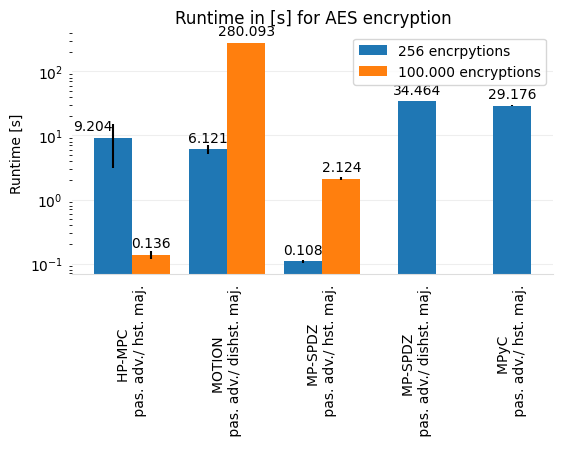

In [13]:
import numpy as np
y_label="Runtime [s]"
titel="Runtime in [s] for AES encryption"
x_label="Protocols"
# Convert the lists to numpy arrays
mean_values = np.array(mean_values)
std_values = np.array(std_values)

# Set the width of the bars
width = 0.4

# Create the figure and axis objects
fig, ax = plt.subplots()
# Plot the bars for mean_values2 next to mean_values1
indices=np.arange(5)
bar1=ax.bar([0,1,2,3.2,4.2], [mean_values[0],mean_values[2],mean_values[4],mean_values[6],mean_values[7]],width,yerr=[std_values[0],std_values[2],std_values[4],std_values[6],std_values[7]], label='256 encrpytions')
# Plot the bars for mean_values1
bar2=ax.bar([0.4,1.4,2.4], [mean_values[1],mean_values[3],mean_values[5]], width,yerr=[std_values[1],std_values[3],std_values[5]], label='100.000 encryptions')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
# Set the x-axis labels
ax.set_xticks(indices + width / 2)
ax.set_xticklabels(labels)

# Set the y-axis label
ax.set_ylabel(y_label)
ax.set_yscale('log')  # Set y-axis as logarithmic
# Set the title
ax.set_title('Runtime in [s] for AES encryption')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
for i,rect in enumerate(bar1):
    if i==0:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2 - 0.22, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    else:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for rect in bar2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
# Add a legend
ax.legend()
fig.tight_layout()
# Show the plot

ax.figure.set_size_inches(5.9, 3)
plt.xticks(rotation='vertical')
plt.savefig(experiment+'_comparison_bar.png',dpi=300, bbox_inches='tight')
plt.show()

In [14]:
def get_bandwidth(data):
    y_values = []
    x_values = []
    labels = []
    for i in range(len(data)):
        if(data[i]['framework'][0] in 'HPMPC'):
            for function in data[i]['function'].unique():
                    for input_size in data[i]['datatype'].unique():
                        y_values.append(data[i].loc[(data[i]['function']==function) & (data[i]['packetdrops(%)'] == 0) & (data[i]['latencies(ms)'] == 0) & (data[i]['preprocess']==0) & (data[i]['datatype']==input_size), ['runtime_external(s)']].to_numpy().reshape(-1)[0:4])
                        x_values.append(data[i]['bandwidths(Mbs)'].unique()[0:4])
                        labels.append("HPMPC passive adversary")
        elif(data[i]['framework'][0] in 'MPyC'):
            y_values.append(data[i].loc[ (data[i]['packetdrops(%)'] == 0) & (data[i]['latencies(ms)'] == 0), ['runtime_external(s)']].to_numpy().reshape(-1)[0:4])
            x_values.append(data[i]['bandwidths(Mbs)'].unique()[0:4])
            labels.append("MPyC")
        else:
            for protocol in data[i]['protocol'].unique():
                if protocol not in ["ps-rep-field","sy-rep-field","malicious-rep-field"]:
                    y_values.append(data[i].loc[(data[i]['packetdrops(%)'] == 0) & (data[i]['latencies(ms)'] == 0) & (data[i]['protocol']==protocol), ['runtime_external(s)']].to_numpy().reshape(-1)[0:4])
                    x_values.append(data[i]['bandwidths(Mbs)'].unique()[0:4])
                    labels.append(data[i]['framework'][0]+ " " + protocol)
    return x_values,y_values,labels

In [ ]:
bandwidth,label = get_bandwidth_deviation(data)
label[0]="HP-MPC pas. adv./ hst. maj."
label[1]="MPyC pas. adv./ hst. maj."
label[2]="MP-SPDZ pas. adv./ hst. maj."
label[3]="MP-SPDZ pas. adv./ dishst. maj."
label[4]="MOTION pas. adv./ dishst. maj."
rf.plot_deviation(bandwidth,label,"AES_Bandwidth_dev.png",experiment,"Bandwidth [Mbit/s]","Runtime [s]",True,x_ticks=[100,5000,10000,15000,20000,25000])

NameError: name 'get_bandwidth_deviation' is not defined

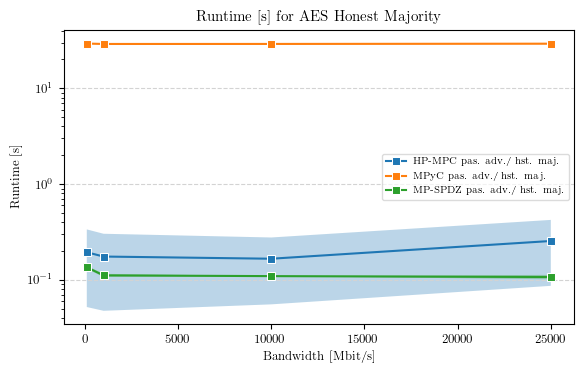

In [7]:
bandwidth_honest = [x for i, x in enumerate(bandwidth) if "dishst." not in label[i]]
label_honest = [x for x in label if "dishst." not in x]
rf.plot_deviation(bandwidth_honest,label_honest,"Bandwidth_dev_honest.png",experiment+" Honest Majority","Bandwidth [Mbit/s]","Runtime [s]",True)

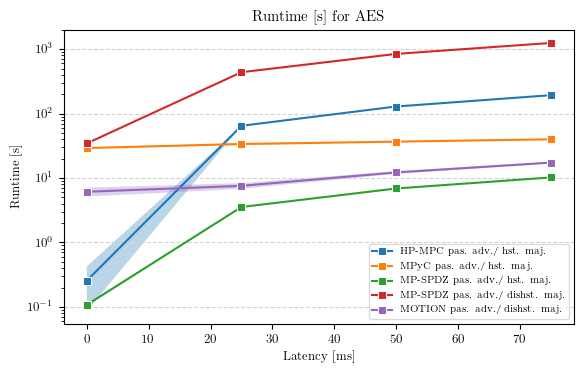

In [8]:
label[0]="HP-MPC pas. adv./ hst. maj."
label[1]="MPyC pas. adv./ hst. maj."
label[2]="MP-SPDZ pas. adv./ hst. maj."
label[3]="MP-SPDZ pas. adv./ dishst. maj."
label[4]="MOTION pas. adv./ dishst. maj."
rf.plot_deviation(latency,label,"Mult_Latency_dev.png",experiment,"Latency [ms]","Runtime [s]",True)

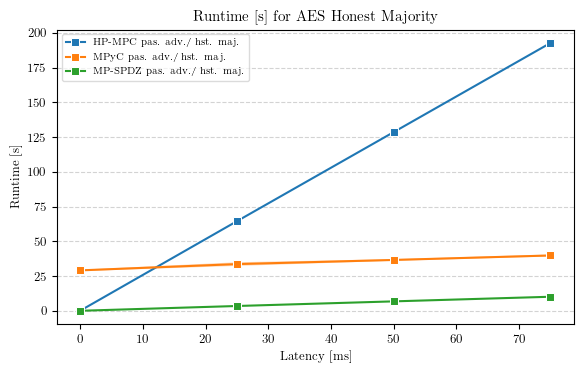

In [9]:
latency_honest = [x for i, x in enumerate(latency) if "dishst." not in label[i]]
label_honest = [x for x in label if "dishst." not in x]
rf.plot_deviation(latency_honest,label_honest,"Latency_dev_honest.png",experiment+" Honest Majority","Latency [ms]","Runtime [s]",False)

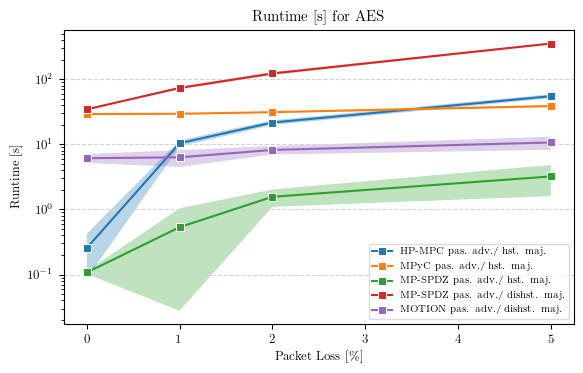

In [10]:
label[0]="HP-MPC pas. adv./ hst. maj."
label[1]="MPyC pas. adv./ hst. maj."
label[2]="MP-SPDZ pas. adv./ hst. maj."
label[3]="MP-SPDZ pas. adv./ dishst. maj."
label[4]="MOTION pas. adv./ dishst. maj."
rf.plot_deviation(packetdrop,label,"Mult_Packetdrop_dev.png",experiment,"Packet Loss [\%]","Runtime [s]",True)

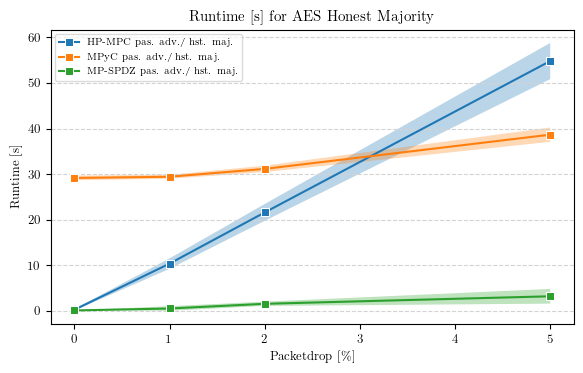

In [11]:
packetdrop_honest = [x for i, x in enumerate(packetdrop) if "dishst." not in label[i]]
label_honest = [x for x in label if "dishst." not in x]
rf.plot_deviation(packetdrop_honest,label_honest,"Mult_Packetdrop_dev_honest.png",experiment+" Honest Majority","Packetdrop [\%]","Runtime [s]",False)



In [39]:
len(packetdrop_honest),len(label_honest)

(6, 6)

In [20]:
latency

[                   mean       std  latencies(ms)
 latencies(ms)                                   
 0                 9.204  6.068804              0
 25             2326.680  0.678823             25
 50             4633.488  0.531263             50
 75             6940.296  0.639500             75,
                    mean       std  latencies(ms)
 latencies(ms)                                   
 0              0.136342  0.019116              0,
                  mean       std  latencies(ms)
 latencies(ms)                                 
 0              29.176  0.511270              0
 25             33.698  1.326950             25
 50             36.672  0.614398             50
 75             39.895  0.716073             75,
                     mean       std  latencies(ms)
 latencies(ms)                                    
 0               0.107667  0.005683              0
 25              3.552000  0.007888             25
 50              6.880000  0.004714             50
 75 

In [18]:
label[0]="HP-MPC \n pas. adv./ hst. maj."
label[1]="MPyC \n pas. adv./ hst. maj."
label[2]="MP-SPDZ \n pas. adv./ hst. maj."
label[3]="MP-SPDZ \n pas. adv./ dishst. maj."
label[4]="MOTION \n pas. adv./ dishst. maj."

In [19]:
y_label="Runtime [s]"
titel="Runtime in [s] for AES"
x_label="Protocols"
mean_values = [round(df['mean'].iloc[0],3) for df in latency]
std_values = [round(df['std'].iloc[0],3) for df in latency]
fig, ax = plt.subplots()
#ax.set_yscale('log')  # Set y-axis as logarithmic
bars=ax.bar(label, mean_values,yerr=std_values,capsize=5)
ax.set_ylabel(y_label)
ax.set_title(titel)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False,)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
# Rotate labels
yval = bars[0].get_height()
plt.text(bars[0].get_x() + bars[0].get_width()/2-0.24, yval + 0.02, yval, ha='center', va='bottom',weight='bold')
# Add values on top of bars
for i,bar in enumerate(bars[1:]):
    if i==1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval  + 0.01, yval, ha='center', va='bottom',weight='bold')
    else:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + std_values[i] + 0.8, yval, ha='center', va='bottom',weight='bold')
ax.figure.set_size_inches(5.9, 2.5)
plt.xticks(rotation='vertical')
plt.savefig(experiment+'_bar.png',dpi=300, bbox_inches='tight')
plt.show()

IndexError: single positional indexer is out-of-bounds

C:\Users\q533604\AppData\Local\Temp\ipykernel_2076\302023580.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  date = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].mean())
C:\Users\q533604\AppData\Local\Temp\ipykernel_2076\302023580.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  err = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].std())
C:\Users\q533604\AppData\Local\Temp\ipykernel_2076\302023580.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  date = float(data[i].loc[ (data[i]['protocol']==protocol), ['peakRAM(MiB)']].mean())
C:\Users\q533604\AppData\Local\Temp\ipykernel_207

[4.06, 335.72, 14.18, 31.01, 1151.98]


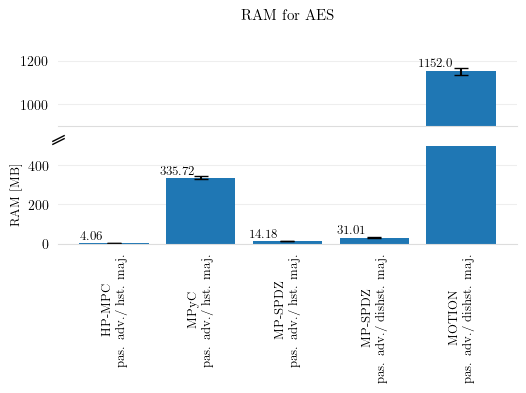

In [38]:
def plot_ram_bar(data,experiment,frameworks):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    values=[]
    label=[]
    error=[]
    for i in range(len(data)):
        if data[i]['framework'][0] == "HPMPC":
            for function in data[i]['function'].unique():
                date = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].mean())
                err = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].std())
                values.append(round(date,2))
                error.append(round(err,2))
                label.append(frameworks[i] + ' honest majority')
        elif data[i]['framework'][0] in ["MP-SPDZ","MOTION"]:
            for protocol in data[i]['protocol'].unique():
                if protocol not in ["ps-rep-field","ps-rep-ring","ps-rep-bin","sy-rep-field","malicious-rep-field"]:
                    date = float(data[i].loc[ (data[i]['protocol']==protocol), ['peakRAM(MiB)']].mean())
                    err = float(data[i].loc[ (data[i]['protocol']==protocol), ['peakRAM(MiB)']].std())
                    values.append(round(date,2))
                    error.append(round(err,2))
                    label.append(frameworks[i]+' '+str(protocol))
        else:
            date = float(data[i]['peakRAM(MiB)'].mean())
            err = float(data[i]['peakRAM(MiB)'].std())
            values.append(round(date,2))
            error.append(round(err,2))
            label.append(frameworks[i])
    label[0]="HP-MPC \n pas. adv./ hst. maj."
    label[1]="MPyC \n pas. adv./ hst. maj."
    label[2]="MP-SPDZ \n pas. adv./ hst. maj."
    label[3]="MP-SPDZ \n pas. adv./ dishst. maj."
    label[4]="MOTION \n pas. adv./ dishst. maj."
    #ax.set_yscale('log')  # Set y-axis as logarithmic
    print(values)
    bars=ax1.bar(label,values,yerr=error,capsize=5)
    bars2=ax2.bar(label,values,yerr=error,capsize=5)
    ax2.set_ylabel('RAM [MB]')
    ax1.set_title('RAM for AES')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_color('#DDDDDD')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_color('#DDDDDD')

    # Second, remove the ticks as well.
    ax1.tick_params(bottom=False, left=False)
    ax2.tick_params(bottom=False, left=False)
    # Third, add a horizontal grid (but keep the vertical grid hidden).
    # Color the lines a light gray as well.
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(True, color='#EEEEEE')
    ax1.xaxis.grid(False)
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(True, color='#EEEEEE')
    ax2.xaxis.grid(False)
    # Rotate labels
    ax1.set_ylim(900,1350)
    ax2.set_ylim(0,500)
    # Add values on top of bars
    for bar in bars2[:-1]:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2 -0.26, yval  +7.5, yval, ha='center', va='bottom',weight='bold')
    yval = bars[-1].get_height()
    plt.text(bars[-1].get_x() + bars[-1].get_width()/2-0.28, yval-260 + 0.05, round(yval,1), ha='center', va='bottom',weight='bold')

    # zoom-in / limit the view to different portions of the data
    ax1.tick_params(axis='y', labelsize=10)
    ax2.tick_params(axis='y', labelsize=10)
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=9,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([-0.15], transform=ax1.transAxes, **kwargs)
    ax2.plot([1.08], transform=ax2.transAxes, **kwargs)
    ax1.figure.set_size_inches(5.91, 2.8)
    ax2.figure.set_size_inches(5.91, 2.8)
    plt.xticks(rotation='vertical')
    plt.savefig(experiment+'_RAM_bar.png',dpi=300,bbox_inches='tight')
    plt.show()
plot_ram_bar(data,experiment,["HPMPC","MPyC","MP-SPDZ","MOTION"])